In [32]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from colorama import Style

# 1. MSBFS-Levels

In [2]:
def MSBFS_Levels(A, start_vertex):
    
    # Проверка на ориентированность графа
    n = A.nrows # Общее количество вершин
    if A.isequal(A.T) and A.nvals>0:
        raise Exception("На вход подается неориентированный граф, а нужен ориентированный! Би карефул!!!")
    
    # Задание начальных параметров для обхода
    m = start_vertex.size # Находим количество строк массива
    result = Matrix(dtypes.INT32, m, n) # Результирующая матрица
    f = Matrix(bool, m, n) # Фронт
    succ = Vector(bool, m)
    
    for i in range(m):
        f[i,start_vertex[i]] << True # Наполнение изначальной матрицы строками
    level=0
    
    # Цикл обхода графа в ширину
    while True:
        result(mask=f.V) << level # Заполнение уровеней
        # Рассчитывание next фронт (матрица смежн * матрица фронта + маска)
        f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)
        for i in range(m):
             # Заполнение вектора наличия доступных вершин (для каждой из стартовых)
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
        # Условия останова (если ни из одной строк(стартовых вершин) на очередной итерации нет доступных вершин)
        true_flag = True
        for i in range(m):
            if succ[i]:
            # Проверка до первого true
                true_flag = False
                break
        if true_flag:
            break
        level += 1 # Счетчик уровней
        
    # Оформление ответа
    # fill недошедших вершины дефолтными значениями
    # На выходе функции должен быть словарь: ключ - номер вершины, значение - массив номеров уровней
    output = {}
    for i in range(m):
        val=[]
        for j in range(n):
            if result[i,j].value is None:
                val.append(-1) # до вершины не добраться -> дефолтное значение "-1"
            else:
                val.append(result[i,j].value)
        output[start_vertex[i]]=np.array(val)
    return output

# 2. MSBFS-Parents

In [3]:
def MSBFS_Parents(A, start_vertex):
    
    # Проверка на ориентированность графа
    N = A.nrows # Общее количество вершин
    if A.isequal(A.T) and A.nvals>0:
        raise Exception("На вход подается неориентированный граф, а нужен ориентированный! Би карефул!!!")
    M = start_vertex.size
    
    # Задание стартовых значений
    # Генерация матрицы, где идентификатор вершины = значению
    index_ramp = Matrix(dtypes.UINT64, M, N)
    
    for i in range(M):
        for j in range(N):
            index_ramp[i,j] << j
            
    parents = Matrix(dtypes.UINT64, M, N)
    
    wavefront = Matrix(dtypes.UINT64, M, N)
    
    for i in range(M):
        # Заполняем изначальную матрицу строками (по номерам соответствующей вершины)
        parents[i,start_vertex[i]] << start_vertex[i]
        wavefront[i, start_vertex[i]] << 1
    
    # Цикл обхода графа
    while wavefront.nvals > 0:
        # Преобразуем все сохраненные значения в wavefront в их индекс
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        
        # Маскирование родительского списка
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        
        # Объединение новых родителей в текущий волновой фронт с существующими родителями
        parents(binary.plus) << wavefront
    
    # Оформление ответа
    # fill недошедших вершины дефолтными значениями
    # На выходе функции должен быть словарь: ключ - номер вершины, значение - массив родительских вершин
    output = {}
    for i in range(M):
        val=[]
        for j in range(N):
            if parents[i,j].value is None:
                val.append(-2) # Нет роодителя -> дефолтное значение "-2"
            elif j==start_vertex[i]:
                val.append(-1) # Родитель = стартовая вершина -> значение "-1"
            else:
                val.append(parents[i,j].value)
        output[start_vertex[i]]=np.array(val)
    return output

# 3. Тесты для проверки корректности полученных реализаций 
## (MSBFS-Levels) и (MSBFS-Parents)

Для проверки на вход будут поданы 3 графа: <br>
1) неориентированный граф (проверка Exception);
2) граф со связанными  вершинами;
3) граф, у которого вершины сгруппированы в "островки".

### Проверка на Exception

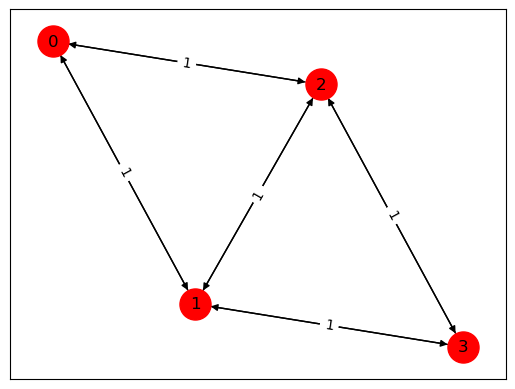

Exception: На вход подается неориентированный граф, а нужен ориентированный! Би карефул!!!

In [6]:
# Создадим простой неориентированный граф с 4 вершинами и 2 треугольниками
matrix1 = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])
M1 = gb.Matrix.from_dense(matrix1, missing_value=0)

gb.viz.draw(M1)

print(MSBFS_Levels(M1, np.array([0, 1, 2, 3])))

In [7]:
print(MSBFS_Parents(M1, np.array([0, 1, 2, 3])))

Exception: На вход подается неориентированный граф, а нужен ориентированный! Би карефул!!!

*Как видим, проверка на ориентированность сработала и вышла ошибка)*

### Проверка с графом со связанными вершинами

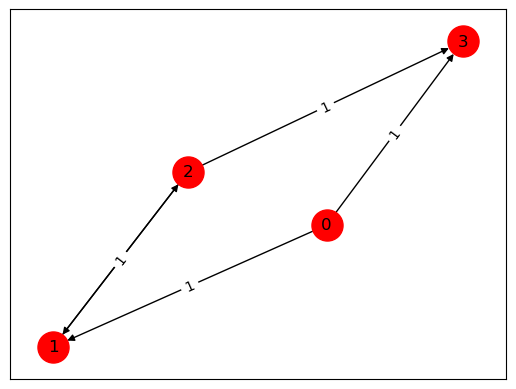

In [20]:
# Создадим простой ориентированный граф с 4 вершинами в форме квадрата
matrix2 = np.array([
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 0]
])
M2 = gb.Matrix.from_dense(matrix2, missing_value=0)

gb.viz.draw(M2)

#### MSBFS-Levels
*начало в вершинах 0, 1, 3* <br>
старт из 0: вершины 1 и 3 - 1го уровня, 2 - 2го уровня \
старт из 1: вершина 2 - 1го уровня, 3 - 2ого уровня, 0 - недостижима \
старт из 3: вершины 0, 1, 2 - недостижимы 

In [21]:
assert (MSBFS_Levels(M2, np.array([0, 1, 3]))[0]==np.array([0, 1, 2, 1])).all()
assert (MSBFS_Levels(M2, np.array([0, 1, 3]))[1]==np.array([-1, 0, 1, 2])).all()
assert (MSBFS_Levels(M2, np.array([0, 1, 3]))[3]==np.array([-1, -1, -1, 0])).all()

#### MSBFS-Parents
*начало в вершинах 0, 1, 3* <br>
старт из 0: вершина 1 достижима из 0; 2 - из 1; 3 из 0 и 2 (ближайшая 0) \
старт из 1: вершина 0 недостижима; вершина 2 достижима из 1; вершина 3 достижима из 0 и 2 (ближайшая 2) \
старт из 3: все вершины недостижимы

In [22]:
assert (MSBFS_Parents(M2, np.array([0, 1, 3]))[0]==np.array([-1, 0, 1, 0])).all()
assert (MSBFS_Parents(M2, np.array([0, 1, 3]))[1]==np.array([-2, -1, 1, 2])).all()
assert (MSBFS_Parents(M2, np.array([0, 1, 3]))[3]==np.array([-2, -2, -2, -1])).all()

### Проверка с графом , у которого вершины сгруппированы в "островки".

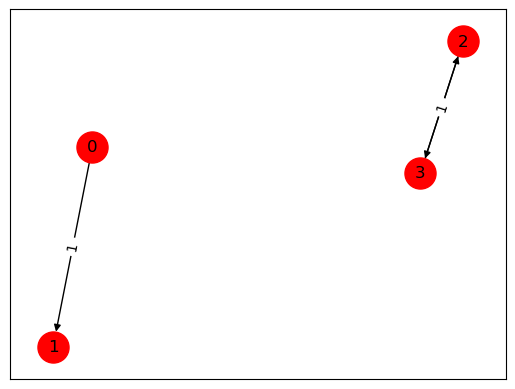

In [26]:
# Создадим граф с 4 вершинами из двух островков
matrix3 = np.array([
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
M3 = gb.Matrix.from_dense(matrix3, missing_value=0)

gb.viz.draw(M3)

#### MSBFS-Levels
*начало в вершинах 1, 2, 3* <br>
старт из 1: вершина 0, 2 и 3 - недостижимы\
старт из 2: вершины 0 и 1 - недостижимы, 3 - 1го уровня\
старт из 3: вершины 0 и 1 - недостижимы, 2 - 1го уровня

In [24]:
assert (MSBFS_Levels(M3, np.array([3, 2, 1]))[3]==np.array([-1, -1, 1, 0])).all()
assert (MSBFS_Levels(M3, np.array([3, 2, 1]))[2]==np.array([-1, -1, 0, 1])).all()
assert (MSBFS_Levels(M3, np.array([3, 2, 1]))[1]==np.array([-1, 0, -1, -1])).all()

#### MSBFS-Parents
*начало в вершинах 1, 2, 3* <br>
старт из 1: вершина 0, 2 и 3 - недостижимы\
старт из 2: вершина 0 и 1 недостижима, вершина 3 достижима из 2\
старт из 3: вершина 0 и 1 недостижима, вершина 2 достижима из 3

In [25]:
assert (MSBFS_Parents(M3, np.array([3, 2, 1]))[3]==np.array([-2, -2, 3, -1])).all()
assert (MSBFS_Parents(M3, np.array([3, 2, 1]))[2]==np.array([-2, -2, -1, 2])).all()
assert (MSBFS_Parents(M3, np.array([3, 2, 1]))[1]==np.array([-2, -1, -2, -2])).all()

# 4. Тестирование на графах с  *SuiteSparse Matrix Collection*

In [40]:
# Функции для тестирования

def gen_vertices(num_vertices, vertex_frac):
    #генерация стартовых вершин в зависимости от числа вершин (num_vertices) и 
    #доли (в %) стартовых вершин от общего числа (vertex_frac)
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)


# тестирование функции "MSBFS_Levels"
def test_Levels(A, start_vertices):
    print('MSBFS_Levels:')
    %timeit MSBFS_Levels(A, start_vertices)
    print()

    
# тестирование функции "MSBFS_Levels"
def test_Parents(A, start_vertices):
    print('MSBFS_Parents:')
    %timeit MSBFS_Parents(A, start_vertices)
    print()

In [43]:
graph_names = ['CSphd', 'GD00_a', 'EPA'] # названия графов
vertex_fracs=[5, 40, 75, 95] # доли стартовых вершин от общего числа

#### Тестирование функции MSBFS-Levels

In [44]:
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'matrixs/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Levels(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Levels:
9.73 s ± 710 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 752
MSBFS_Levels:
1min 21s ± 5.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1411
MSBFS_Levels:
2min 25s ± 3.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1787
MSBFS_Levels:
3min 1s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Levels:
350 ms ± 71.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
MSBFS_Levels:
2.76 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
MSBFS_Levels:
5.39 s ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### Тестирование функции MSBFS-Parents

In [46]:
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'matrixs/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        if graph_name != 'EPA':
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Parents(graph, gen_vertices(graph.nrows, vertex_frac))
        elif vertex_frac < 50:
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Parents(graph, gen_vertices(graph.nrows, vertex_frac))    
    print()

Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Parents:
14.9 s ± 452 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 752
MSBFS_Parents:
2min 5s ± 1.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1411
MSBFS_Parents:
3min 59s ± 2.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1787
MSBFS_Parents:
5min 5s ± 4.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Parents:
557 ms ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
MSBFS_Parents:
4.78 s ± 440 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
MSBFS_Parents:
8.29 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop e

### Тестирование на случайно сгенерированных графах

In [47]:
# Функция генерации случайного графа
def generate_graph(num_vertices, num_edges):
    # создание множества, состоящего из номеров ячеек матрицы (без диагональных элементов)
    positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)

    # Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер
    gen_indices = random.sample(positions, num_edges)
    
    # Преобразование индексов в координаты (строка, столбец)
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    
    return gb.Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=num_vertices, ncols=num_vertices)

####  Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)

In [48]:
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels(generated_graph, gen_vertices(i, num_starts))
    test_Parents(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
671 ms ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
785 ms ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
2.49 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
3.08 s ± 379 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
9.78 s ± 600 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
12.7 s ± 722 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
38.1 s ± 965 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
50.7 s ± 513 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



#### Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)

In [49]:
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents(generated_graph, gen_vertices(num_vert, num_starts))

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
MSBFS_Levels:
14.8 s ± 531 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
20.5 s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
MSBFS_Levels:
15.7 s ± 1.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
19.9 s ± 642 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
MSBFS_Levels:
15 s ± 374 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
19.5 s ± 581 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
MSBFS_Levels:
15.7 s ± 895 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
19.8 s ± 322 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



#### Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)

In [51]:
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    test_Levels(generated_graph, gen_vertices(num_vert, i))
    test_Parents(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
MSBFS_Levels:
5.76 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
7.84 s ± 383 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
MSBFS_Levels:
12 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
15.8 s ± 577 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
MSBFS_Levels:
17.9 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
23.9 s ± 795 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
MSBFS_Levels:
24.1 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
31.3 s ± 406 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### Выводы:
- Когда количество вершин увеличивается (при степени разреженности 0.5 и количестве стартовых вершин 50%), время работы обоих алгоритмов также увеличивается. Это происходит из-за увеличения количества столбцов в матрицах, что усложняет операцию матричного умножения. Алгоритм MSBFS_Levels демонстрирует примерно линейную зависимость времени от количества вершин, в то время как второй алгоритм имеет степенную зависимость.

- При росте количества стартовых вершин (при постоянном количестве вершин равном 500 и степени разреженности 50%) также наблюдается увеличение времени работы алгоритмов. В обоих случаях эта зависимость близка к линейной. Это объясняется тем, что увеличение количества стартовых вершин непосредственно влияет на размерность строк фронта, что усложняет операцию матричного умножения.

- При увеличении степени разреженности (при уплотнении графа) явной зависимости не наблюдается. Более того, тесты показали, что алгоритмы работают быстрее на графах со средней степенью разреженности. Это можно объяснить тем, что алгоритмы оптимизированы для реальных графов, которые редко бывают почти полными или крайне разреженными.

- В сравнении друг с другом функций, MSBFS_Parents начинает работать дольше, чем MSBFS_Levels, по мере увеличения размеров графа.

#  5. Реализации алгоритмов с использованием других полуколец  
### (*any.pair* для levels и *any.first* для parents)

**Поменяем полукольцо в параметре semiring на any_pair в реализации функции для levels и any_first - parents**

In [52]:
def MSBFS_Levels_anypair(A, start_vertex):
    
    # Проверка на ориентированность графа
    n = A.nrows # Общее количество вершин
    if A.isequal(A.T) and A.nvals>0:
        raise Exception("На вход подается неориентированный граф, а нужен ориентированный! Би карефул!!!")
    
    # Задание начальных параметров для обхода
    m = start_vertex.size # Находим количество строк массива
    result = Matrix(dtypes.INT32, m, n) # Результирующая матрица
    f = Matrix(bool, m, n) # Фронт
    succ = Vector(bool, m)
    
    for i in range(m):
        f[i,start_vertex[i]] << True # Наполнение изначальной матрицы строками
    level=0
    
    # Цикл обхода графа в ширину
    while True:
        result(mask=f.V) << level # Заполнение уровеней
        # Рассчитывание next фронт (матрица смежн * матрица фронта + маска)
        '''меняем на any_pair'''
        f(~result.S, replace=True) << f.mxm(A, semiring.any_pair)
        for i in range(m):
             # Заполнение вектора наличия доступных вершин (для каждой из стартовых)
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
        # Условия останова (если ни из одной строк(стартовых вершин) на очередной итерации нет доступных вершин)
        true_flag = True
        for i in range(m):
            if succ[i]:
            # Проверка до первого true
                true_flag = False
                break
        if true_flag:
            break
        level += 1 # Счетчик уровней
        
    # Оформление ответа
    # fill недошедших вершины дефолтными значениями
    # На выходе функции должен быть словарь: ключ - номер вершины, значение - массив номеров уровней
    output = {}
    for i in range(m):
        val=[]
        for j in range(n):
            if result[i,j].value is None:
                val.append(-1) # до вершины не добраться -> дефолтное значение "-1"
            else:
                val.append(result[i,j].value)
        output[start_vertex[i]]=np.array(val)
    return output

In [53]:
def MSBFS_Parents_anyfirst(A, start_vertex):
    
    # Проверка на ориентированность графа
    N = A.nrows # Общее количество вершин
    if A.isequal(A.T) and A.nvals>0:
        raise Exception("На вход подается неориентированный граф, а нужен ориентированный! Би карефул!!!")
    M = start_vertex.size
    
    # Задание стартовых значений
    # Генерация матрицы, где идентификатор вершины = значению
    index_ramp = Matrix(dtypes.UINT64, M, N)
    
    for i in range(M):
        for j in range(N):
            index_ramp[i,j] << j
            
    parents = Matrix(dtypes.UINT64, M, N)
    
    wavefront = Matrix(dtypes.UINT64, M, N)
    
    for i in range(M):
        # Заполняем изначальную матрицу строками (по номерам соответствующей вершины)
        parents[i,start_vertex[i]] << start_vertex[i]
        wavefront[i, start_vertex[i]] << 1
    
    # Цикл обхода графа
    while wavefront.nvals > 0:
        # Преобразуем все сохраненные значения в wavefront в их индекс
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        
        # Маскирование родительского списка
        '''меняем на any_first'''
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
        
        # Объединение новых родителей в текущий волновой фронт с существующими родителями
        parents(binary.plus) << wavefront
    
    # Оформление ответа
    # fill недошедших вершины дефолтными значениями
    # На выходе функции должен быть словарь: ключ - номер вершины, значение - массив родительских вершин
    output = {}
    for i in range(M):
        val=[]
        for j in range(N):
            if parents[i,j].value is None:
                val.append(-2) # Нет роодителя -> дефолтное значение "-2"
            elif j==start_vertex[i]:
                val.append(-1) # Родитель = стартовая вершина -> значение "-1"
            else:
                val.append(parents[i,j].value)
        output[start_vertex[i]]=np.array(val)
    return output

#### Функции для тестирования

In [54]:
# тестирование функции MSBFS_Levels_anypair
def test_Levels_anypair(A, start_vertex):
    print('MSBFS_Levels_anypair:')
    %timeit MSBFS_Levels_anypair(A, start_vertex)
    print()

    
# тестирование функции MSBFS_Levels_anyfirst
def test_Parents_anyfirst(A, start_vertex):
    print('MSBFS_Parents_anyfirst:')
    %timeit MSBFS_Parents_anyfirst(A, start_vertex)
    print()

#### Тестирование на графах с *SuiteSparse Matrix Collection*

##### Тестирование функции MSBFS-Levels_anypair

In [55]:
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'matrixs/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        if graph_name != 'EPA':
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Levels_anypair(graph, gen_vertices(graph.nrows, vertex_frac))
        elif vertex_frac < 50:
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Levels_anypair(graph, gen_vertices(graph.nrows, vertex_frac)) 
#         print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
#         test_Levels_anypair(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Levels_anypair:
9.41 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 752
MSBFS_Levels_anypair:
1min 17s ± 1.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1411
MSBFS_Levels_anypair:
2min 26s ± 1.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1787
MSBFS_Levels_anypair:
3min 4s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Levels_anypair:
310 ms ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
MSBFS_Levels_anypair:
2.74 s ± 409 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
MSBFS_Levels_anypair:
5.18 s ± 44

##### Тестирование функции MSBFS-Parents_anyfirst

In [57]:
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'matrixs/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        if graph_name != 'EPA':
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Parents_anyfirst(graph, gen_vertices(graph.nrows, vertex_frac))
        elif vertex_frac < 50:
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Parents_anyfirst(graph, gen_vertices(graph.nrows, vertex_frac))
#         print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
#         test_Parents_anyfirst(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Parents_anyfirst:
14.2 s ± 509 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 752
MSBFS_Parents_anyfirst:
2min 6s ± 3.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1411
MSBFS_Parents_anyfirst:
3min 55s ± 6.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1787
MSBFS_Parents_anyfirst:
4min 55s ± 2.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Parents_anyfirst:
550 ms ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
MSBFS_Parents_anyfirst:
4.25 s ± 248 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
MSBFS_Parents_anyfirst

### Тестирование на случайно сгенерированных графах

#### Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)

In [58]:
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels_anypair(generated_graph, gen_vertices(i, num_starts))
    test_Parents_anyfirst(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
603 ms ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
777 ms ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
2.38 s ± 272 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
3.2 s ± 410 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
9.5 s ± 286 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
11.8 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
37.3 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
48.8 s ± 726 ms per lo

#### Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)

In [59]:
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents_anyfirst(generated_graph, gen_vertices(num_vert, num_starts))

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
14.5 s ± 301 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
18.8 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
14.8 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
19.1 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
14.4 s ± 458 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
19.2 s ± 422 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
14.6 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
18.5 s ± 309 ms per 

#### Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)

In [60]:
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, i))
    test_Parents_anyfirst(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
MSBFS_Levels_anypair:
5.73 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
7.58 s ± 419 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
MSBFS_Levels_anypair:
11.4 s ± 673 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
15.3 s ± 363 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
MSBFS_Levels_anypair:
17.3 s ± 465 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
22.8 s ± 813 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
MSBFS_Levels_anypair:
23.6 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
30.7 s ± 192 ms per 

## Выводы

- Levels. При крайних значениях (малых графах, очень разреженных или очень плотных, небольшом количестве стартовых вершин) алгоритм в начальном полукольце показывает лучшую скорость. Тем не менее, при увеличении плотности графа, его размеров и количества стартовых вершин (то есть при приближении к реальным практическим задачам) полукольцо any_pair демонстрирует меньшее время выполнения.

- Parents. При приближении графов к реальным задачам алгоритм с использованием полукольца any_first дает сравнимое время (при малых значениях изначальное полукольцо работает быстрее). Я считаю, что это связано с выбором первого или же с поиском минимального элемента, соответственно выбирая первого, мы получаем более эффективную стратегию при большом количестве подходящих. Однако, при увеличении количества стартовых вершин изначальное полукольцо показывает значительно лучшую производительность. Скорее всего выбор минимального элемента осуществляется по хитрой схеме, которая не уступает стратегии выбора первого подходящего.